In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generating training sets

In [2]:
training_sets = []
batch_size = [1000]
for idx,size in enumerate(batch_size):
    training_data = torch.zeros((size,101))
    for row in range(size):
        training_data[row],_ = torch.sort(torch.randint(1,100,(101,)))
        if torch.randint(0,2,(1,)).item() == 1:
            training_data[row][0] = training_data[row][100] = 100
        else:
            training_data[row][0] = training_data[row][100] = 101

    # One-hot encoding for the target variable -> (size,101,101)
    target = torch.zeros(training_data.shape[0],training_data.shape[1],training_data.shape[1])
    for row in range(target.shape[0]):
        for seq in range(target.shape[1]):
            target[row][seq][int(training_data[row][seq])-1] = 1.0
    
    training_sets.append(target)
    print(f"Training set - {idx+1} Generated")

Training set - 1 Generated


# Generating Test sets

In [3]:
test_datasets = []
for dataset in range(10):
    
    test_data = torch.zeros((3000,101))
    for row in range(3000):
        test_data[row],_ = torch.sort(torch.randint(1,100,(101,)))
        if torch.randint(0,2,(1,)).item() == 1:
            test_data[row][0] = test_data[row][100] = 100
        else:
            test_data[row][0] = test_data[row][100] = 101

    # test_data = test_data[torch.randperm(test_data.shape[0])]

    # One-hot encoding for the target variable -> (3000,101,101)
    target_test = torch.zeros(test_data.shape[0],test_data.shape[1],test_data.shape[1])
    for row in range(target_test.shape[0]):
        for seq in range(target_test.shape[1]):
            target_test[row][seq][int(test_data[row][seq])-1] = 1.0
    
    test_datasets.append(target_test)
    print(f"Test set - {dataset+1} Generated")

Test set - 1 Generated
Test set - 2 Generated
Test set - 3 Generated
Test set - 4 Generated
Test set - 5 Generated
Test set - 6 Generated
Test set - 7 Generated
Test set - 8 Generated
Test set - 9 Generated
Test set - 10 Generated


# Models (RNN and LSTM)
### Architecture
- Input size kept to be 101
- Number of layers = 1
- Hidden size kept to be 150
- Using batch gradient descent with training batch size 1500
- Linear layer which compresses the hidden layer output to dimensions of the classes ie 101
- Using Softmax to calculate the predicted probability of each class
- KL Divergence as the loss criterion

**Experimentation**
Experimented with the hidden layer size and number of layers. Most achitectures performed well for lstm but RNN found it difficult to converge.

**Conclusion**
The actual output depends solely on the input { y(ap,a1,a2 .... ap-1) = ap } hence ideally the function must learn this one to one dependency between the inital input and final output. But since the sequence length is 100, models that face Problems to address long term dependency for reasons like vanishing gradients Eg RNN almost never converge. Models like LSTMs designed to address this converge well and in all cases.

In [4]:
class SeqPredictorRNN(nn.Module):
    def __init__(self, input_size, batch_size, hidden_size,num_layers):
        super(SeqPredictorRNN, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.rnn_cell = nn.RNNCell(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size,2)
        self.linear_general = nn.Linear(hidden_size,101)
        self.smax = nn.LogSoftmax(dim = 1)

    def forward(self, x,teacher_ratio):
        self.initial_hidden = torch.rand(self.num_layers,x.shape[0],self.hidden_size)
        outputs = []
        hidden_states = []
        for timestep in range(100):
            h_t = []
            if(timestep== 0):
                h_t = self.rnn_cell(x[:,timestep], self.initial_hidden[0])
            else:
                input = []
                if(torch.rand(1).item() < teacher_ratio):
                    input = x[:,timestep]
                else:
                    input = torch.zeros_like(x[:,0])
                    temp = torch.argmax(outputs[-1],dim=1)
                    for row in range(input.shape[0]):
                        input[row][temp[row]] = 1.0
                    
                h_t = self.rnn_cell(input, hidden_states[-1])
            hidden_states.append(h_t)
            if(timestep < 99):
                out = self.smax(self.linear_general(h_t))
            else:
                out = self.smax(self.linear_general(h_t))
            outputs.append(out)
            
#         _, final_hidden = self.rnn(x,self.initial_hidden)
#         out = self.smax(self.linear(final_hidden[0]))
        return outputs[-1]

class SeqPredictorLSTM(nn.Module):
    def __init__(self, input_size, batch_size, hidden_size,num_layers):
        super(SeqPredictorLSTM, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm_cell = nn.LSTMCell(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size,2)
        self.linear_general = nn.Linear(hidden_size,101)
        self.smax = nn.LogSoftmax(dim = 1)

    def forward(self, x,teacher_ratio):
        self.initial_hidden = torch.rand(self.num_layers,x.shape[0],self.hidden_size)
        self.initial_cell = torch.rand(self.num_layers,x.shape[0],self.hidden_size)

        outputs = []
        hidden_states = []
        cell_states = []
        for timestep in range(100):
            h_t = []
            c_t = []
            if(timestep== 0):
                (h_t,c_t) = self.lstm_cell(x[:,timestep], (self.initial_hidden[0],self.initial_cell[0]))
            else:
                input = []
                if(torch.rand(1).item() < teacher_ratio):
                    input = x[:,timestep]
                else:
                    input = torch.zeros_like(x[:,0])
                    temp = torch.argmax(outputs[-1],dim=1)
                    for row in range(input.shape[0]):
                        input[row][temp[row]] = 1.0
                    
                (h_t,c_t) = self.lstm_cell(input, (hidden_states[-1],cell_states[-1]))
            hidden_states.append(h_t)
            cell_states.append(c_t)
            if(timestep < 99):
                out = self.smax(self.linear_general(h_t))
            else:
                out = self.smax(self.linear_general(h_t))
            outputs.append(out)
            
#         _, final_hidden = self.rnn(x,self.initial_hidden)
#         out = self.smax(self.linear(final_hidden[0]))
        return outputs[-1]

# RNN training

In [10]:
losses = []
for idx,training_data in enumerate(training_sets):
    model_rnn = SeqPredictorRNN(101,training_data.shape[0],150,1)
    criterion = nn.KLDivLoss(reduction = "batchmean")
    optimizer = optim.Adam(model_rnn.parameters(), lr=0.001)

    # Training loop
    num_epochs = 1000
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model_rnn(training_data[:,:-1],1.0)
        loss = criterion(output, training_data[:,-1])
        losses.append(loss)
        loss.backward()
        optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    

Epoch [1/1000], Loss: 4.6638
Epoch [2/1000], Loss: 4.5745
Epoch [3/1000], Loss: 4.4862
Epoch [4/1000], Loss: 4.4196
Epoch [5/1000], Loss: 4.2960
Epoch [6/1000], Loss: 4.1421
Epoch [7/1000], Loss: 3.9121
Epoch [8/1000], Loss: 3.5586
Epoch [9/1000], Loss: 3.1037
Epoch [10/1000], Loss: 2.6477
Epoch [11/1000], Loss: 2.2668
Epoch [12/1000], Loss: 1.9454
Epoch [13/1000], Loss: 1.6664
Epoch [14/1000], Loss: 1.5089
Epoch [15/1000], Loss: 1.7562
Epoch [16/1000], Loss: 2.7164
Epoch [17/1000], Loss: 3.0413
Epoch [18/1000], Loss: 3.8729
Epoch [19/1000], Loss: 4.8348
Epoch [20/1000], Loss: 4.9880
Epoch [21/1000], Loss: 5.6641
Epoch [22/1000], Loss: 6.0669
Epoch [23/1000], Loss: 6.2175
Epoch [24/1000], Loss: 6.5076
Epoch [25/1000], Loss: 6.3117
Epoch [26/1000], Loss: 6.1008
Epoch [27/1000], Loss: 6.0234
Epoch [28/1000], Loss: 5.9504
Epoch [29/1000], Loss: 5.7576
Epoch [30/1000], Loss: 5.7288
Epoch [31/1000], Loss: 5.3265
Epoch [32/1000], Loss: 5.0229
Epoch [33/1000], Loss: 4.8098
Epoch [34/1000], Lo

Epoch [269/1000], Loss: 0.6957
Epoch [270/1000], Loss: 0.6957
Epoch [271/1000], Loss: 0.6957
Epoch [272/1000], Loss: 0.6957
Epoch [273/1000], Loss: 0.6957
Epoch [274/1000], Loss: 0.6956
Epoch [275/1000], Loss: 0.6956
Epoch [276/1000], Loss: 0.6951
Epoch [277/1000], Loss: 0.6956
Epoch [278/1000], Loss: 0.6950
Epoch [279/1000], Loss: 0.6955
Epoch [280/1000], Loss: 0.6955
Epoch [281/1000], Loss: 0.6950
Epoch [282/1000], Loss: 0.6955
Epoch [283/1000], Loss: 0.7197
Epoch [284/1000], Loss: 0.7198
Epoch [285/1000], Loss: 0.6954
Epoch [286/1000], Loss: 0.7075
Epoch [287/1000], Loss: 0.6954
Epoch [288/1000], Loss: 0.6954
Epoch [289/1000], Loss: 0.6954
Epoch [290/1000], Loss: 0.6953
Epoch [291/1000], Loss: 0.6954
Epoch [292/1000], Loss: 0.6953
Epoch [293/1000], Loss: 0.6948
Epoch [294/1000], Loss: 0.7071
Epoch [295/1000], Loss: 0.6948
Epoch [296/1000], Loss: 0.6953
Epoch [297/1000], Loss: 0.6947
Epoch [298/1000], Loss: 0.6953
Epoch [299/1000], Loss: 0.7074
Epoch [300/1000], Loss: 0.6952
Epoch [3

Epoch [534/1000], Loss: 0.6922
Epoch [535/1000], Loss: 0.6938
Epoch [536/1000], Loss: 0.6922
Epoch [537/1000], Loss: 0.6922
Epoch [538/1000], Loss: 0.6922
Epoch [539/1000], Loss: 0.6938
Epoch [540/1000], Loss: 0.6922
Epoch [541/1000], Loss: 0.6922
Epoch [542/1000], Loss: 0.6921
Epoch [543/1000], Loss: 0.6937
Epoch [544/1000], Loss: 0.6937
Epoch [545/1000], Loss: 0.6937
Epoch [546/1000], Loss: 0.6935
Epoch [547/1000], Loss: 0.6935
Epoch [548/1000], Loss: 0.6937
Epoch [549/1000], Loss: 0.6921
Epoch [550/1000], Loss: 0.6937
Epoch [551/1000], Loss: 0.6933
Epoch [552/1000], Loss: 0.6921
Epoch [553/1000], Loss: 0.6920
Epoch [554/1000], Loss: 0.6937
Epoch [555/1000], Loss: 0.6937
Epoch [556/1000], Loss: 0.6919
Epoch [557/1000], Loss: 0.6937
Epoch [558/1000], Loss: 0.6920
Epoch [559/1000], Loss: 0.6920
Epoch [560/1000], Loss: 0.6934
Epoch [561/1000], Loss: 0.6937
Epoch [562/1000], Loss: 0.6920
Epoch [563/1000], Loss: 0.6937
Epoch [564/1000], Loss: 0.6937
Epoch [565/1000], Loss: 0.6937
Epoch [5

Epoch [799/1000], Loss: 0.6924
Epoch [800/1000], Loss: 0.6906
Epoch [801/1000], Loss: 0.6935
Epoch [802/1000], Loss: 0.6935
Epoch [803/1000], Loss: 0.6934
Epoch [804/1000], Loss: 0.6923
Epoch [805/1000], Loss: 0.6937
Epoch [806/1000], Loss: 0.6923
Epoch [807/1000], Loss: 0.6929
Epoch [808/1000], Loss: 0.6934
Epoch [809/1000], Loss: 0.6935
Epoch [810/1000], Loss: 0.6905
Epoch [811/1000], Loss: 0.6933
Epoch [812/1000], Loss: 0.6938
Epoch [813/1000], Loss: 0.6906
Epoch [814/1000], Loss: 0.6905
Epoch [815/1000], Loss: 0.6922
Epoch [816/1000], Loss: 0.6934
Epoch [817/1000], Loss: 0.6934
Epoch [818/1000], Loss: 0.6906
Epoch [819/1000], Loss: 0.6933
Epoch [820/1000], Loss: 0.6928
Epoch [821/1000], Loss: 0.6904
Epoch [822/1000], Loss: 0.6933
Epoch [823/1000], Loss: 0.6904
Epoch [824/1000], Loss: 0.6933
Epoch [825/1000], Loss: 0.6931
Epoch [826/1000], Loss: 0.6932
Epoch [827/1000], Loss: 0.6904
Epoch [828/1000], Loss: 0.6932
Epoch [829/1000], Loss: 0.6933
Epoch [830/1000], Loss: 0.6933
Epoch [8

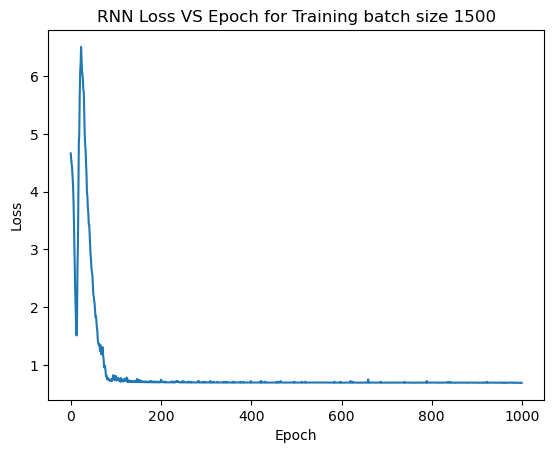

In [11]:
plt.plot(range(1000),[los.item() for los in losses])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("RNN Loss VS Epoch for Training batch size 1500")
plt.show()

In [12]:
for idx,test in enumerate(test_datasets):
    model_rnn.eval()
    with torch.no_grad():
        output = model_rnn(test[:,:-1],0.0)
        predictions = torch.argmax(output,dim=1)
        actual = torch.argmax(test[:,-1],dim=1)
        wrong_pred = torch.where(predictions != actual,1.0,0.0)
        print(f'Average(over batch) no. of Wrong predictions in set - {idx} : {100*(torch.sum(wrong_pred) / wrong_pred.shape[0]):.4f}%')
        idx+=1

Average(over batch) no. of Wrong predictions in set - 0 : 51.3000%
Average(over batch) no. of Wrong predictions in set - 1 : 50.2667%
Average(over batch) no. of Wrong predictions in set - 2 : 50.7667%
Average(over batch) no. of Wrong predictions in set - 3 : 51.1000%
Average(over batch) no. of Wrong predictions in set - 4 : 48.9000%
Average(over batch) no. of Wrong predictions in set - 5 : 49.7333%
Average(over batch) no. of Wrong predictions in set - 6 : 49.5000%
Average(over batch) no. of Wrong predictions in set - 7 : 50.7667%
Average(over batch) no. of Wrong predictions in set - 8 : 48.5000%
Average(over batch) no. of Wrong predictions in set - 9 : 50.2000%


# LSTM Training

In [14]:
losses = []
for idx,training_data in enumerate(training_sets):
    model_lstm = SeqPredictorLSTM(101,training_data.shape[0],150,1)
    criterion = nn.KLDivLoss(reduction = "batchmean")
    optimizer = optim.Adam(model_lstm.parameters(), lr=0.001)

    # Training loop
    num_epochs = 1000
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model_lstm(training_data[:,:-1],1.0)
        loss = criterion(output, training_data[:,-1])
        losses.append(loss)
        loss.backward()
        optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/1000], Loss: 4.6221
Epoch [2/1000], Loss: 4.5895
Epoch [3/1000], Loss: 4.5555
Epoch [4/1000], Loss: 4.5193
Epoch [5/1000], Loss: 4.4792
Epoch [6/1000], Loss: 4.4333
Epoch [7/1000], Loss: 4.3787
Epoch [8/1000], Loss: 4.3110
Epoch [9/1000], Loss: 4.2224
Epoch [10/1000], Loss: 4.0979
Epoch [11/1000], Loss: 3.9022
Epoch [12/1000], Loss: 3.5383
Epoch [13/1000], Loss: 2.8607
Epoch [14/1000], Loss: 2.2399
Epoch [15/1000], Loss: 1.8256
Epoch [16/1000], Loss: 1.5251
Epoch [17/1000], Loss: 1.2965
Epoch [18/1000], Loss: 1.1233
Epoch [19/1000], Loss: 0.9957
Epoch [20/1000], Loss: 0.9046
Epoch [21/1000], Loss: 0.8411
Epoch [22/1000], Loss: 0.7976
Epoch [23/1000], Loss: 0.7679
Epoch [24/1000], Loss: 0.7475
Epoch [25/1000], Loss: 0.7334
Epoch [26/1000], Loss: 0.7234
Epoch [27/1000], Loss: 0.7163
Epoch [28/1000], Loss: 0.7110
Epoch [29/1000], Loss: 0.7072
Epoch [30/1000], Loss: 0.7043
Epoch [31/1000], Loss: 0.7022
Epoch [32/1000], Loss: 0.7007
Epoch [33/1000], Loss: 0.6995
Epoch [34/1000], Lo

Epoch [269/1000], Loss: 0.6879
Epoch [270/1000], Loss: 0.6878
Epoch [271/1000], Loss: 0.6876
Epoch [272/1000], Loss: 0.6875
Epoch [273/1000], Loss: 0.6873
Epoch [274/1000], Loss: 0.6870
Epoch [275/1000], Loss: 0.6868
Epoch [276/1000], Loss: 0.6868
Epoch [277/1000], Loss: 0.6890
Epoch [278/1000], Loss: 0.7036
Epoch [279/1000], Loss: 0.6927
Epoch [280/1000], Loss: 0.6865
Epoch [281/1000], Loss: 0.6945
Epoch [282/1000], Loss: 0.6871
Epoch [283/1000], Loss: 0.6903
Epoch [284/1000], Loss: 0.6868
Epoch [285/1000], Loss: 0.6894
Epoch [286/1000], Loss: 0.6873
Epoch [287/1000], Loss: 0.6880
Epoch [288/1000], Loss: 0.6886
Epoch [289/1000], Loss: 0.6874
Epoch [290/1000], Loss: 0.6879
Epoch [291/1000], Loss: 0.6883
Epoch [292/1000], Loss: 0.6875
Epoch [293/1000], Loss: 0.6877
Epoch [294/1000], Loss: 0.6880
Epoch [295/1000], Loss: 0.6874
Epoch [296/1000], Loss: 0.6873
Epoch [297/1000], Loss: 0.6876
Epoch [298/1000], Loss: 0.6871
Epoch [299/1000], Loss: 0.6870
Epoch [300/1000], Loss: 0.6871
Epoch [3

Epoch [534/1000], Loss: 0.6909
Epoch [535/1000], Loss: 0.6910
Epoch [536/1000], Loss: 0.6914
Epoch [537/1000], Loss: 0.6916
Epoch [538/1000], Loss: 0.6914
Epoch [539/1000], Loss: 0.6911
Epoch [540/1000], Loss: 0.6908
Epoch [541/1000], Loss: 0.6908
Epoch [542/1000], Loss: 0.6909
Epoch [543/1000], Loss: 0.6911
Epoch [544/1000], Loss: 0.6911
Epoch [545/1000], Loss: 0.6909
Epoch [546/1000], Loss: 0.6908
Epoch [547/1000], Loss: 0.6907
Epoch [548/1000], Loss: 0.6907
Epoch [549/1000], Loss: 0.6908
Epoch [550/1000], Loss: 0.6908
Epoch [551/1000], Loss: 0.6908
Epoch [552/1000], Loss: 0.6907
Epoch [553/1000], Loss: 0.6906
Epoch [554/1000], Loss: 0.6906
Epoch [555/1000], Loss: 0.6906
Epoch [556/1000], Loss: 0.6906
Epoch [557/1000], Loss: 0.6906
Epoch [558/1000], Loss: 0.6905
Epoch [559/1000], Loss: 0.6905
Epoch [560/1000], Loss: 0.6905
Epoch [561/1000], Loss: 0.6905
Epoch [562/1000], Loss: 0.6905
Epoch [563/1000], Loss: 0.6905
Epoch [564/1000], Loss: 0.6904
Epoch [565/1000], Loss: 0.6904
Epoch [5

Epoch [799/1000], Loss: 0.6858
Epoch [800/1000], Loss: 0.6857
Epoch [801/1000], Loss: 0.6855
Epoch [802/1000], Loss: 0.6854
Epoch [803/1000], Loss: 0.6853
Epoch [804/1000], Loss: 0.6851
Epoch [805/1000], Loss: 0.6848
Epoch [806/1000], Loss: 0.6844
Epoch [807/1000], Loss: 0.6839
Epoch [808/1000], Loss: 0.6831
Epoch [809/1000], Loss: 0.6842
Epoch [810/1000], Loss: 0.6932
Epoch [811/1000], Loss: 0.6899
Epoch [812/1000], Loss: 0.6884
Epoch [813/1000], Loss: 0.6884
Epoch [814/1000], Loss: 0.6894
Epoch [815/1000], Loss: 0.6897
Epoch [816/1000], Loss: 0.6889
Epoch [817/1000], Loss: 0.6882
Epoch [818/1000], Loss: 0.6884
Epoch [819/1000], Loss: 0.6890
Epoch [820/1000], Loss: 0.6890
Epoch [821/1000], Loss: 0.6884
Epoch [822/1000], Loss: 0.6881
Epoch [823/1000], Loss: 0.6884
Epoch [824/1000], Loss: 0.6886
Epoch [825/1000], Loss: 0.6885
Epoch [826/1000], Loss: 0.6881
Epoch [827/1000], Loss: 0.6880
Epoch [828/1000], Loss: 0.6882
Epoch [829/1000], Loss: 0.6883
Epoch [830/1000], Loss: 0.6881
Epoch [8

In [6]:
# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model_lstm(training_data[:,:-1],1.0)
    loss = criterion(output, training_data[:,-1])
    losses.append(loss)
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/1000], Loss: 0.6882
Epoch [2/1000], Loss: 0.6882
Epoch [3/1000], Loss: 0.6882
Epoch [4/1000], Loss: 0.6882
Epoch [5/1000], Loss: 0.6882
Epoch [6/1000], Loss: 0.6882
Epoch [7/1000], Loss: 0.6882
Epoch [8/1000], Loss: 0.6882
Epoch [9/1000], Loss: 0.6882
Epoch [10/1000], Loss: 0.6882
Epoch [11/1000], Loss: 0.6881
Epoch [12/1000], Loss: 0.6881
Epoch [13/1000], Loss: 0.6881
Epoch [14/1000], Loss: 0.6881
Epoch [15/1000], Loss: 0.6881
Epoch [16/1000], Loss: 0.6881
Epoch [17/1000], Loss: 0.6881
Epoch [18/1000], Loss: 0.6881
Epoch [19/1000], Loss: 0.6881
Epoch [20/1000], Loss: 0.6881
Epoch [21/1000], Loss: 0.6881
Epoch [22/1000], Loss: 0.6881
Epoch [23/1000], Loss: 0.6881
Epoch [24/1000], Loss: 0.6881
Epoch [25/1000], Loss: 0.6881
Epoch [26/1000], Loss: 0.6881
Epoch [27/1000], Loss: 0.6881
Epoch [28/1000], Loss: 0.6881
Epoch [29/1000], Loss: 0.6881
Epoch [30/1000], Loss: 0.6881
Epoch [31/1000], Loss: 0.6880
Epoch [32/1000], Loss: 0.6880
Epoch [33/1000], Loss: 0.6880
Epoch [34/1000], Lo

Epoch [269/1000], Loss: 0.6863
Epoch [270/1000], Loss: 0.6863
Epoch [271/1000], Loss: 0.6862
Epoch [272/1000], Loss: 0.6862
Epoch [273/1000], Loss: 0.6862
Epoch [274/1000], Loss: 0.6862
Epoch [275/1000], Loss: 0.6862
Epoch [276/1000], Loss: 0.6862
Epoch [277/1000], Loss: 0.6862
Epoch [278/1000], Loss: 0.6862
Epoch [279/1000], Loss: 0.6862
Epoch [280/1000], Loss: 0.6861
Epoch [281/1000], Loss: 0.6861
Epoch [282/1000], Loss: 0.6861
Epoch [283/1000], Loss: 0.6861
Epoch [284/1000], Loss: 0.6861
Epoch [285/1000], Loss: 0.6861
Epoch [286/1000], Loss: 0.6861
Epoch [287/1000], Loss: 0.6861
Epoch [288/1000], Loss: 0.6861
Epoch [289/1000], Loss: 0.6860
Epoch [290/1000], Loss: 0.6860
Epoch [291/1000], Loss: 0.6860
Epoch [292/1000], Loss: 0.6860
Epoch [293/1000], Loss: 0.6860
Epoch [294/1000], Loss: 0.6860
Epoch [295/1000], Loss: 0.6860
Epoch [296/1000], Loss: 0.6860
Epoch [297/1000], Loss: 0.6860
Epoch [298/1000], Loss: 0.6859
Epoch [299/1000], Loss: 0.6859
Epoch [300/1000], Loss: 0.6859
Epoch [3

Epoch [534/1000], Loss: 0.6794
Epoch [535/1000], Loss: 0.6793
Epoch [536/1000], Loss: 0.6793
Epoch [537/1000], Loss: 0.6792
Epoch [538/1000], Loss: 0.6791
Epoch [539/1000], Loss: 0.6791
Epoch [540/1000], Loss: 0.6790
Epoch [541/1000], Loss: 0.6789
Epoch [542/1000], Loss: 0.6788
Epoch [543/1000], Loss: 0.6788
Epoch [544/1000], Loss: 0.6787
Epoch [545/1000], Loss: 0.6786
Epoch [546/1000], Loss: 0.6786
Epoch [547/1000], Loss: 0.6785
Epoch [548/1000], Loss: 0.6784
Epoch [549/1000], Loss: 0.6783
Epoch [550/1000], Loss: 0.6783
Epoch [551/1000], Loss: 0.6782
Epoch [552/1000], Loss: 0.6781
Epoch [553/1000], Loss: 0.6780
Epoch [554/1000], Loss: 0.6780
Epoch [555/1000], Loss: 0.6779
Epoch [556/1000], Loss: 0.6778
Epoch [557/1000], Loss: 0.6777
Epoch [558/1000], Loss: 0.6777
Epoch [559/1000], Loss: 0.6776
Epoch [560/1000], Loss: 0.6775
Epoch [561/1000], Loss: 0.6774
Epoch [562/1000], Loss: 0.6774
Epoch [563/1000], Loss: 0.6773
Epoch [564/1000], Loss: 0.6772
Epoch [565/1000], Loss: 0.6771
Epoch [5

Epoch [799/1000], Loss: 0.0146
Epoch [800/1000], Loss: 0.0201
Epoch [801/1000], Loss: 0.0146
Epoch [802/1000], Loss: 0.0031
Epoch [803/1000], Loss: 0.0031
Epoch [804/1000], Loss: 0.0201
Epoch [805/1000], Loss: 0.0030
Epoch [806/1000], Loss: 0.0030
Epoch [807/1000], Loss: 0.0030
Epoch [808/1000], Loss: 0.0030
Epoch [809/1000], Loss: 0.0086
Epoch [810/1000], Loss: 0.0086
Epoch [811/1000], Loss: 0.0029
Epoch [812/1000], Loss: 0.0028
Epoch [813/1000], Loss: 0.0086
Epoch [814/1000], Loss: 0.0028
Epoch [815/1000], Loss: 0.0143
Epoch [816/1000], Loss: 0.0027
Epoch [817/1000], Loss: 0.0027
Epoch [818/1000], Loss: 0.0202
Epoch [819/1000], Loss: 0.0143
Epoch [820/1000], Loss: 0.0026
Epoch [821/1000], Loss: 0.0085
Epoch [822/1000], Loss: 0.0084
Epoch [823/1000], Loss: 0.0142
Epoch [824/1000], Loss: 0.0084
Epoch [825/1000], Loss: 0.0026
Epoch [826/1000], Loss: 0.0026
Epoch [827/1000], Loss: 0.0084
Epoch [828/1000], Loss: 0.0084
Epoch [829/1000], Loss: 0.0025
Epoch [830/1000], Loss: 0.0083
Epoch [8

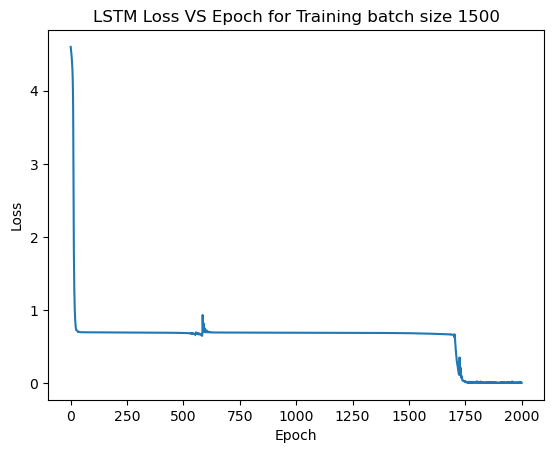

In [7]:
plt.plot(range(2000),[los.item() for los in losses])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("LSTM Loss VS Epoch for Training batch size 1500")
plt.show()

In [8]:
for idx,test in enumerate(test_datasets):
    model_lstm.eval()
    with torch.no_grad():
        output = model_lstm(test[:,:-1],0.0)
        predictions = torch.argmax(output,dim=1)
        actual = torch.argmax(test[:,-1],dim=1)
        wrong_pred = torch.where(predictions != actual,1.0,0.0)
        print(f'Average(over batch) no. of Wrong predictions in set - {idx} : {100*(torch.sum(wrong_pred) / wrong_pred.shape[0]):.4f}%')
        idx+=1

Average(over batch) no. of Wrong predictions in set - 0 : 44.1000%
Average(over batch) no. of Wrong predictions in set - 1 : 45.4000%
Average(over batch) no. of Wrong predictions in set - 2 : 44.7333%
Average(over batch) no. of Wrong predictions in set - 3 : 44.4667%
Average(over batch) no. of Wrong predictions in set - 4 : 46.5667%
Average(over batch) no. of Wrong predictions in set - 5 : 45.6000%
Average(over batch) no. of Wrong predictions in set - 6 : 45.8333%
Average(over batch) no. of Wrong predictions in set - 7 : 44.3000%
Average(over batch) no. of Wrong predictions in set - 8 : 46.7333%
Average(over batch) no. of Wrong predictions in set - 9 : 45.1000%


In [ ]:
print(predictions)